In [ ]:
%load_ext autoreload
%autoreload 2
%autosave 60

# NYC dataset

# Basics

## Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from pandas_profiling import ProfileReport
from pprint import pprint


## For geomap purpose
import folium

## For checking missing values
import missingno as msno

## For test/train splititng
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'

## local helper class
from helper_class import *
%matplotlib inline

In [2]:
#! python3 -m pip install --user dtreeviz

## upload dataset

In [3]:
def get_dataset(local_dir_name):
    '''
    param local_dir_name: name of the directory to which the dataset belongs to

    assume that variable 'DirForLocalDataset' is set systemwide
    Returns pandas dataframe
    '''
    path_dataset = os.getenv("DirForLocalDataset") + '/'+ local_dir_name
    print("following dataset is available:",os.listdir(path_dataset) )
    df = pd.read_csv(os.path.join(path_dataset, os.listdir(path_dataset)[1]))
    return df

In [4]:
path_dataset = os.getenv("DirForLocalDataset") + '/'+ 'axa_dataset'
df_bike = pd.read_csv(os.path.join(path_dataset, os.listdir(path_dataset)[3]))
df_bike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1


# insight into data

In [5]:
print(f"Shape of dataset is {df_bike.shape}")
print(df_bike.dtypes)

Shape of dataset is (1953103, 15)
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object


In [6]:
df_bike.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06,1.953103e+06
mean,1.211320e+03,1.587847e+03,4.073682e+01,-7.398272e+01,1.580168e+03,4.073646e+01,-7.398288e+01,2.599782e+04,1.978870e+03,1.137163e+00
std,2.559797e+04,1.437212e+03,3.328542e-02,1.950168e-02,1.436349e+03,3.313123e-02,1.956221e-02,5.846984e+03,1.175118e+01,5.699493e-01
min,6.100000e+01,7.200000e+01,4.065540e+01,-7.402535e+01,7.200000e+01,4.065540e+01,-7.405570e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.860000e+02,3.790000e+02,4.071689e+01,-7.399599e+01,3.790000e+02,4.071644e+01,-7.399612e+01,2.020500e+04,1.969000e+03,1.000000e+00
50%,6.600000e+02,5.040000e+02,4.073705e+01,-7.398602e+01,5.030000e+02,4.073705e+01,-7.398658e+01,2.766200e+04,1.981000e+03,1.000000e+00
75%,1.157000e+03,3.236000e+03,4.075763e+01,-7.397189e+01,3.236000e+03,4.075725e+01,-7.397210e+01,3.100700e+04,1.989000e+03,1.000000e+00
max,7.571338e+06,3.692000e+03,4.550636e+01,-7.356891e+01,3.692000e+03,4.550636e+01,-7.356891e+01,3.369900e+04,2.002000e+03,2.000000e+00


In [7]:
df_bike.isnull().sum() * 100 / len(df_bike)

tripduration               0.0
starttime                  0.0
stoptime                   0.0
start station id           0.0
start station name         0.0
start station latitude     0.0
start station longitude    0.0
end station id             0.0
end station name           0.0
end station latitude       0.0
end station longitude      0.0
bikeid                     0.0
usertype                   0.0
birth year                 0.0
gender                     0.0
dtype: float64

## Profiling

In [8]:
profile = ProfileReport(df_bike, title="Pandas Profiling Report")
#profile

## Quick Statistics

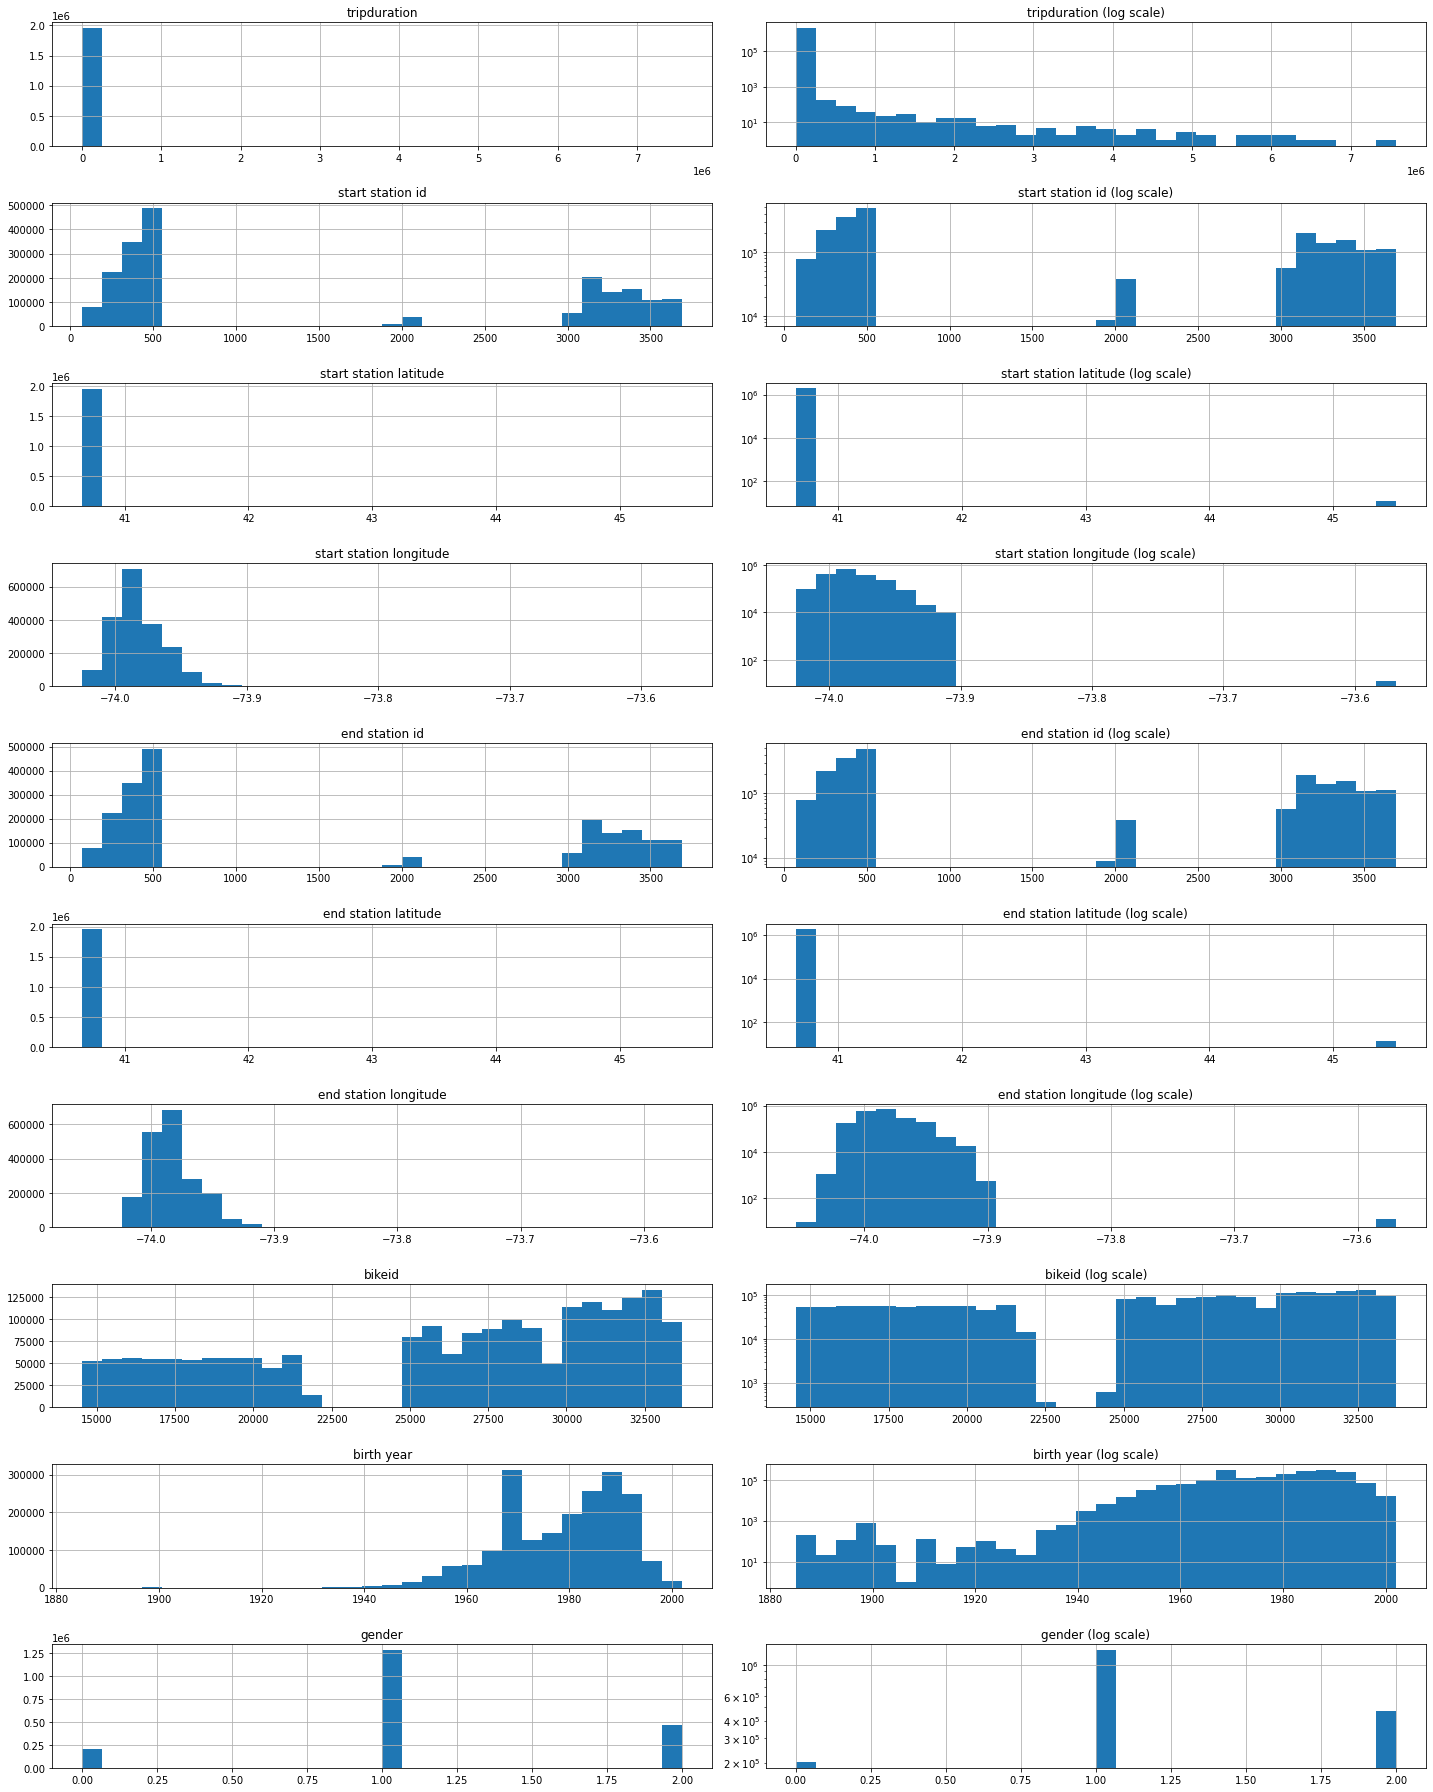

In [9]:
draw_stats(df_bike)

Observations:
1. few D.O.B are dated 1900, ie. 118 years old.
2. trip durations got maximum of around 4e6, i.e. 46 days

## Check coorrelation

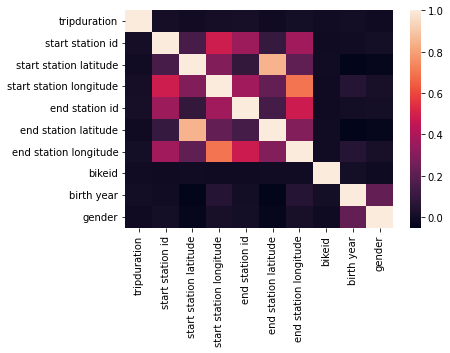

In [10]:
corr = df_bike.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.savefig('heatmap_coorelation_plot.png')

# Preprocessing
1. lets first take care of the 2 variable, tripduration and D.O.B cases.

## Tripduration

### Tripduration in min/hrs

In [11]:
df_bike['duration_mins'] = df_bike['tripduration']/60
df_bike['duration_hr']   = df_bike['tripduration']/(60*60)

In [12]:
print(df_bike['duration_hr'].describe())

count    1.953103e+06
mean     3.364777e-01
std      7.110546e+00
min      1.694444e-02
25%      1.072222e-01
50%      1.833333e-01
75%      3.213889e-01
max      2.103149e+03
Name: duration_hr, dtype: float64


### Tripduration in hr
1. The maximum is 2013 hrs, that's around 83 days.
2. Another important aspect is that there are 25% value between (0.32, 2013) hrs, in which, thankfully, the lower bound still is quite reasonable.
3. my understanding says 24 hr, ie. whole day, is quite an extreme value for renting bike.

In [13]:
print("count is:", df_bike['duration_hr'][df_bike['duration_hr']>24].count())

count is: 837


In [14]:
#sns.histplot(x=df_bike['duration_hr'][df_bike['duration_hr']>24], log_scale=True)
#plt.title("Distribution of duration (hr) > 24 hr")
#plt.xlabel("Duration (hr) (log scale)")
#plt.ylabel('Count')

### Lets drop ca 800 evens of tripduration(hr) > 24

In [15]:
print(f"shape of original: {df_bike.shape}, after filtering dataset: {df_bike[df_bike['duration_hr'] < 24].shape}")
df_bike = df_bike[df_bike['duration_hr'] < 24]

shape of original: (1953103, 17), after filtering dataset: (1952266, 17)


In [16]:
df_bike.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
duration_mins              0
duration_hr                0
dtype: int64

## Users

### Calculate age of the users

shape of such events: (2179,)


Text(0, 0.5, 'Count')

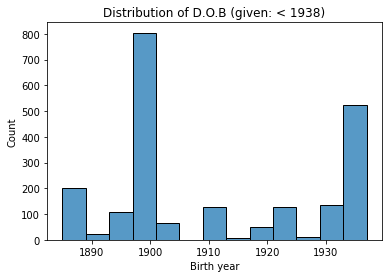

In [17]:
print('shape of such events:', df_bike['birth year'][df_bike['birth year'] < 1938].shape)
sns.histplot(x=df_bike['birth year'][df_bike['birth year'] < 1938])
plt.title("Distribution of D.O.B (given: < 1938)")
plt.xlabel("Birth year")
plt.ylabel('Count')

In [18]:
df_bike['age'] = (pd.DatetimeIndex(df_bike['starttime']).year - df_bike['birth year'])
df_bike.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,duration_hr,age
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1,9.483333,0.158056,19
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1,8.000000,0.133333,30
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1,11.533333,0.192222,32


In [19]:
df_bike.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
duration_mins              0
duration_hr                0
age                        0
dtype: int64

Text(0.5, 0, 'Age')

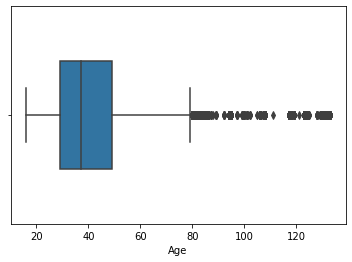

In [20]:
#sns.set_theme(style="whitegrid")
sns.boxplot(x=df_bike["age"], width=0.5)
plt.xlabel("Age")

In [21]:
#skip = (df_bike.loc[:, ('age')] > 80)
df_bike = df_bike[df_bike['age'] <  81]
df_bike.shape

(1950087, 18)

Text(0, 0.5, 'Trips')

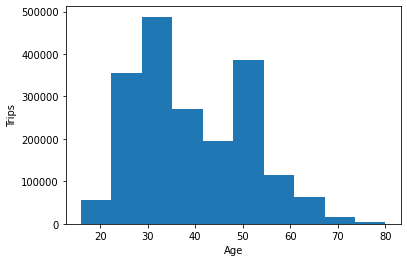

In [22]:
plt.hist(df_bike['age'])
#plt.title("Distribution of Usertype during Weekday")
plt.xlabel("Age")
plt.ylabel('Trips')

### Convert gender as string categorical

In [23]:
df_bike.groupby('gender').size()

gender
0     201192
1    1279968
2     468927
dtype: int64

<AxesSubplot:ylabel='gender'>

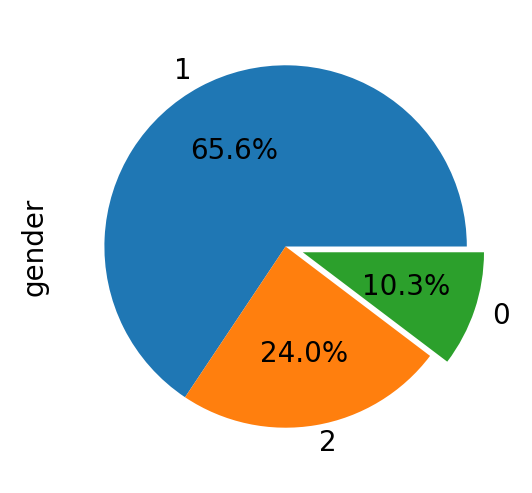

In [24]:
fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.subplot(111)
explode = (0, 0,0.1)
df_bike['gender'].value_counts().plot(kind='pie', ax=ax,explode=explode, autopct='%1.1f%%', startangle=0, fontsize=10)

## Time

### Convert timestamp to datetime variable

In [25]:
df_bike["starttime"] = pd.to_datetime(df_bike['starttime'], format='%Y-%m-%d %H:%M:%S') 
df_bike["stoptime"]  = pd.to_datetime(df_bike['stoptime'], format='%Y-%m-%d %H:%M:%S')

### Calculate Month/time/weekday from timetamp

In [26]:
df_bike['month']= df_bike['starttime'].dt.month_name()
df_bike['time'] =  df_bike['starttime'].dt.time
df_bike['weekday'] = df_bike['starttime'].dt.day_name()
df_bike['hour'] = df_bike['starttime'].dt.hour
df_bike['date'] = df_bike['starttime'].dt.date

In [27]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cat_type = CategoricalDtype(categories=cats, ordered=True)
df_bike['weekday'] = df_bike['weekday'].astype(cat_type)

In [28]:
df_bike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,duration_mins,duration_hr,age,month,time,weekday,hour,date
0,569,2018-06-01 01:57:20.514,2018-06-01 02:06:50.088,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,...,1999,1,9.483333,0.158056,19,June,01:57:20.514000,Friday,1,2018-06-01
1,480,2018-06-01 02:02:42.398,2018-06-01 02:10:43.354,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,...,1988,1,8.000000,0.133333,30,June,02:02:42.398000,Friday,2,2018-06-01


### Which year/month the dataset belongs to?

In [29]:
df_bike['month'].value_counts()

June    1950087
Name: month, dtype: int64

## Geo Info

### Calculate distance between start/end

In [30]:
def get_distance(lat1, lon1, lat2, lon2):
    earth_radius=6371
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))    

In [31]:
df_bike['dist_km'] = get_distance(df_bike["start station latitude"], df_bike["start station longitude"], 
                                    df_bike["end station latitude"], df_bike["end station longitude"])

### Station information

In [ ]:
print(df_bike['start station id'].unique().shape)

## Missing values

In [ ]:
df_bike.shape

In [ ]:
df_bike.isnull().sum() * 100 / len(df_bike)

In [ ]:
fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.subplot(111)
df_bike['usertype'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, fontsize=10)

# Explanatory Analysis

### frequency of user's gender?

In [ ]:
# Pie chart
labels = get_label_size_list(df_bike, 'gender')[0]
sizes =  get_label_size_list(df_bike, 'gender')[1]
explode = (0, 0.1,0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
plt.savefig('piedist_gender.png')

###  How users are distributed during Weekdays?

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

df_bike[df_bike['usertype']=="Customer"].groupby("weekday")["usertype"].count().plot(ax=ax, label='Customer', marker='o',legend=True)
df_bike[df_bike['usertype']=="Subscriber"].groupby("weekday")["usertype"].count().plot(ax=ax, label='Subscriber', marker='o', legend=True)
plt.title("Distribution of Trips during Week")
plt.xlabel("Weekday")
plt.ylabel('No of Trips')
plt.savefig("usertype_during_weekday.png")

###  Age vs Weekday Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
weekday = ("Monday" or "Tuesday" or "Wednesday" or "Thursday")
df_bike[df_bike['weekday']==weekday].groupby("age")["weekday"].count().plot(ax=ax, label='Workday', marker='o',legend=True)
df_bike[df_bike['weekday']=="Friday"].groupby("age")["weekday"].count().plot(ax=ax, label='Friday', marker='o',legend=True)
df_bike[df_bike['weekday'] == ("Sunday" or "Saturday")].groupby("age")["weekday"].count().plot(ax=ax, label='Weekend', marker='o',legend=True)


plt.title("Distribution of Bike User's Age during the week")
plt.xlabel("Age")
plt.ylabel('No of Trips')
plt.savefig("agedist_during_week.png")

In [ ]:
#sns.set(rc={'figure.figsize':(8,5)})
#sns.set_theme(style="whitegrid")
#bplot=sns.boxplot(x="weekday", y="age", palette="colorblind", data=df_bike)
##bplot.axes.set_title("Distribution of age during Weekday", fontsize=16)
#bplot.set_ylabel("Age", fontsize=14)
#bplot.set_xlabel("Weekday", fontsize=14)
#plt.savefig('age_weekday_boxplot.png')

### How many Unique bikes are avaialble?

In [ ]:
#bplot=sns.histplot(df_bike["bikeid"].unique())
#bplot.set_xlabel("Unique BikeId", fontsize=14)
#plt.savefig("Unique_bikes.png")
print("number of unique bike-id is: ", df_bike["bikeid"].unique().shape)

### Distribution of Users age vs gender

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))


df_bike[df_bike['gender']==0].groupby("age")["age"].count().plot(ax=ax, label='0', marker='o',legend=True)
df_bike[df_bike['gender']==1].groupby("age")["age"].count().plot(ax=ax, label='1', marker='o',legend=True)
df_bike[df_bike['gender']==2].groupby("age")["age"].count().plot(ax=ax, label='2', marker='o',legend=True)


plt.title("Distribution of User's Age vs Gender")
plt.xlabel("Age")
plt.ylabel('Count')
plt.savefig("age_vs_gender.png")

### Trip vs User gender 

In [ ]:
trip_counts = df_bike.groupby('gender')['tripduration'].count()
plt.rcParams.update({'font.size': 14})
plt.barh([0, 1, 2], trip_counts / 1000, align = 'center', alpha = 0.5)
plt.yticks([0, 1, 2])
plt.xlabel('Thoudands of trips')
plt.title('Distribution of trips according to user gender')
plt.show()

### Distribution of trip duration

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.hist(df_bike['duration_mins'][(df_bike['duration_mins'] < 60) & (df_bike['duration_mins'] != 0 )] )
#plt.tick_params(axis = 'both', which = 'major')
#plt.title('Distribution of trip durations\n')
plt.xlabel('Count of trips by duration (min)')
plt.ylabel('Trip counts')

In [ ]:
df_bike['duration_mins'].describe() ## (mean, sd) : (22, 151) minuetes 

In [ ]:
# Plot the distribution of trip durations
plt.rcParams.update({'font.size': 14})
df_bike['duration_mins'][(df_bike['duration_mins']< 60) & (df_bike['duration_mins'] !=0)].hist(figsize = (8,5), bins = 10, alpha = 0.5)
plt.title('Distribution of trip durations\n')
plt.xlabel('Duration (min.)')
plt.ylabel('Trip counts')

## Frequency of trips per day per hour

In [ ]:
df_1 = df_bike[df_bike["start station name"] == "Central Park S & 6 Ave"]
df_1 = df_1.loc[:, ['tripduration', 'starttime']] 
df_1.index = df_1['starttime']

In [ ]:
june2_sat  = df_1[df_1.index.date == pd.Timestamp(2018, 6, 2)]
june3_sun  = df_1[df_1.index.date == pd.Timestamp(2018, 6, 3)]
june4_mon  = df_1[df_1.index.date == pd.Timestamp(2018, 6, 4)]

june2_countsPerHr  = june2_sat.groupby(june2_sat.index.hour).size()
june3_countsPerHr  = june3_sun.groupby(june3_sun.index.hour).size()
june4_countsPerHr  = june4_mon.groupby(june4_mon.index.hour).size()

In [ ]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
legend = ax.legend(loc='upper left', frameon = False)

june3_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Sun, Jun3', legend=True, figsize = (10, 6))


june2_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Sam, Jun2', legend=True)


june4_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Mon, Jun4', legend=True)



plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips/hour from Central Park S & 6 Ave')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
plt.plot()

In [ ]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df_bike.loc[:, ['tripduration', 'starttime']] 
df_sub.index = df_sub['starttime']
monday  = df_sub[df_sub.index.weekday == 0]
tuesday = df_sub[df_sub.index.weekday == 1]
wednesday = df_sub[df_sub.index.weekday == 2]
monday_countsPerHr  = monday.groupby(monday.index.hour).size()
tuesday_countsPerHr = tuesday.groupby(tuesday.index.hour).size()
wednesday_countsPerHr = wednesday.groupby(wednesday.index.hour).size()

In [ ]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})

tuesday_countsPerHr.plot(kind = 'line', stacked = False,  figsize = (10, 6),
                          linewidth = 2, label='Tuesday', legend=True)


wednesday_countsPerHr.plot(kind = 'line', stacked = False, 
                          linewidth = 2, label='Wednesday', legend=True)

monday_countsPerHr.plot(kind = 'line', stacked = False,
                          linewidth = 2, label='Monday', legend=True)



plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips per hour')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

### Frequency of trips per hrs

In [ ]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df_bike.loc[:, ['tripduration', 'starttime']] 
df_sub.index = df_sub['starttime']
weekdays = df_sub[df_sub.index.weekday < 5]
weekends = df_sub[df_sub.index.weekday > 4]
weekdays_countsPerHr = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr = weekends.groupby(weekends.index.hour).size()

In [ ]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr.plot(kind = 'area', stacked = False, figsize = (10, 6),
                          linewidth = 2, label='Weekdays', legend=True)

weekends_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Weekends', legend=True)

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips per hour')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

### Frequency of trips per day

In [ ]:
df_1 = df_bike[(df_bike["start station name"] == "Central Park S & 6 Ave") & 
               (df_bike.index.date == pd.Timestamp(2013, 6, 1))]

In [ ]:
df_bike.index = df_bike['starttime']
countsPerDay = df_bike.starttime.resample('D').agg('count')

In [ ]:
countsPerDay.plot(kind = 'area', stacked = False, figsize = (15, 5), linewidth = 2)
#plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Number of trips per day')
plt.xlabel('Date')
plt.ylabel('Number of trips')

### Which station had the oldest riders on average

In [ ]:
n_trip=120 #1258
cut = df_bike[df_bike['age']>60].groupby(['start station name','end station name']).filter(lambda x: x['tripduration'].count() >= n_trip) 

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))
plt.hist(cut['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Older riders (> 60 years)')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

### Most Populer Customer Trip

In [ ]:
n_trip=500 #1258
cut=df_bike[df_bike['usertype']=='Customer'].groupby(['start station name', 'end station name']).filter(lambda x: x['tripduration'].count() >= n_trip) 

In [ ]:
plt.hist(cut['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Customers')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

In [ ]:
print(cut['start station name'].unique(), cut['end station name'].unique(),cut['age'].unique())
print(cut['gender'].unique(), cut['age'].median())

### Most populer Subscriber Trip

In [ ]:
df_subs=df_bike[df_bike['usertype']=='Subscriber'].groupby(['start station name', 'end station name']).filter(lambda x: x['tripduration'].count() >= 600)
df_subs.shape

In [ ]:
plt.hist(df_subs['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Subscriber')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

In [ ]:
print(df_subs['start station name'].unique(), df_subs['end station name'].unique(),df_subs['gender'].unique())
print(df_subs['weekday'].unique(), df_subs['age'].median())

In [ ]:
sns.histplot(df_subs['duration_hr'])

In [ ]:
#import dtale
#dtale.show(df_bike)

In [ ]:
df_bike.shape

### Geometry 
https://livecodestream.dev/post/how-to-plot-your-data-on-maps-using-python-and-folium/
https://towardsdatascience.com/visualizing-bike-mobility-in-london-using-interactive-maps-for-absolute-beginners-3b9f55ccb59    

In [ ]:
### Find most common start and end routes 
import folium
df_sub = df_bike[['start station name','end station name', 'start station latitude','start station longitude','end station latitude','end station longitude']]
# df_routes = df_sub.groupby(['Start Station Name','Start Station Latitude', 'Start Station Longitude', 'End Station Name', 'End Station Latitude','End Station Longitude']).size().reset_index(name='Counts of trips')

# df_routes = df_routes.nlargest(50, columns=['Counts of trips'])
# # print(df_routes)

# df_sub = df_sub[df_sub['Start Station Name'] != df_sub['End Station Name']]
df_sub['both'] = df_sub['start station name'] + ', ' + df_sub['end station name']
# # perform the transformation asked
df_sub = df_sub.groupby(['start station name','start station latitude', 'start station longitude', 'end station name', 'end station latitude','end station longitude'])['both'].count().reset_index(name='Counts of trips')
df_sub = df_sub.nsmallest(100, columns=['Counts of trips'])


In [ ]:
map1 = folium.Map(
    
    location=[40.732775,-74.105973],
    tiles='cartodbpositron',
    zoom_start= 15,
    max_width= 150, max_height=150
)


df_sub.apply(lambda row:folium.CircleMarker(location=[row["start station latitude"], row["start station longitude"]], popup=row["start station name"],radius=5, color="Red").add_to(map1), axis=1)
#df_sub.apply(lambda row:folium.CircleMarker(location=[row["start station latitude"], row["start station longitude"]],popup=row["start station name"], color='green').add_to(map1), axis=1)


map1

In [ ]:
import geopandas as gpd
street_map = gpd.read_file("/Users/psaxena/Downloads/NYS_Civil_Boundaries/Counties.shp")

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=us_states,
    name='choropleth',
    data=df_bike,
    columns=['start station lattitude', 'age'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate %'
).add_to(m)

m

In [ ]:
gdf = geopandas.GeoDataFrame(df_bike, geometry=geopandas.points_from_xy(df_bike["start station longitude"], 
                                                                        df_bike["start station latitude"]))

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
plt.hist(df_bike["start station id"].unique())

In [ ]:
plt.hist(df_bike["start station id"])
print("number of unique start-station-id is: ", df_bike["start station id"].unique().shape)

In [ ]:
sns.histplot(df_bike["end station id"].unique())
print("number of unique end-station-id is: ", df_bike["end station id"].unique().shape)

In [ ]:
sns.countplot(data=df_bike, x='start station id', order=df_bike["start station id"].value_counts().index)

In [ ]:
sns.displot(data=df_bike, x="age", hue='usertype', multiple='stack', aspect=10/5); 

In [ ]:
plt.boxplot(df_bike['duration_mins'])
print(df_bike['duration_mins'].describe())

# Modelling

## Splitting of train / val / test dataset

In [32]:
def get_class_counts(df, label, count_var):
    '''
    param df : pandas dataframe
    param label : label as string
    
    Give class counts of the label in df
    
    Eg: df = pd.DataFrame({'Team':['Riders', 'Riders', 'Riders', 'Kings','Kings'], 
                           'year':['2016','2016','2015','2018','2016']})
       get_class_counts(df, label='Team', count_var='year') will give you:
       {'Kings': 2, 'Riders': 3}  
    '''
    grp = df.groupby([label])[count_var].count()
    return {key: grp[key] for key in list(grp.keys())}


def get_class_proportions(df, label, count_var):
    '''
    param df: pandas dataframe
    param label : label as string
    
    Give proportion of the label class in df dataset. 
    
    Eg: df = pd.DataFrame({'Team':['Riders', 'Riders', 'Riders', 'Kings','Kings'], 
                           'year':['2016','2016','2015','2018','2016']})
        get_class_proportions(df, label='Team', count_var='year') will give you:
        {'Kings': 0.4, 'Riders': 0.6}
    '''
    class_counts = get_class_counts(df, label, count_var)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

In [33]:
from sklearn.model_selection import train_test_split

def data_split(dataset, label, count_var, train_frac, random_state=123):
    ''' 
    param dataset  : Data to be split
    param label    : label as string
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    train, tmp = train_test_split(dataset, train_size=train_frac, random_state=random_state, shuffle=True,
                                  stratify=dataset[label])
    val, test  = train_test_split(tmp, train_size=0.5, random_state=random_state, shuffle=True,
                                  stratify=tmp[label])
    
    print(f"Class proportion: \n in train: {get_class_proportions(train, label, count_var)} \n in val: {get_class_proportions(val, label, count_var)} \n in test: {get_class_proportions(test, label, count_var)}")
    return train, val, test

In [34]:
selected_columns = df_bike[['duration_mins','gender', 'start station id','age', 'weekday','hour', 'usertype']]
df_bike_model = selected_columns.copy()

df_bike_model.head(3) 

,duration_mins,gender,start station id,age,weekday,hour,usertype
0,9.483333,1,72,19,Friday,1,Subscriber
1,8.000000,1,72,30,Friday,2,Subscriber
2,11.533333,1,72,32,Friday,2,Subscriber


In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in df_bike_model.columns:
    if df_bike_model[column_name].dtype.name == 'category' or df_bike_model[column_name].dtype == object:
        df_bike_model[column_name] = le.fit_transform(df_bike_model[column_name])
    else:
        pass

In [36]:
train, val, test = data_split(df_bike_model, label='usertype', count_var='hour',train_frac=0.8)

Class proportion: 
 in train: {0: 0.1321, 1: 0.8679} 
 in val: {0: 0.1321, 1: 0.8679} 
 in test: {0: 0.1321, 1: 0.8679}


In [37]:
print(train.shape, val.shape, test.shape) #1560069

(1560069, 7) (195009, 7) (195009, 7)


## Algorithm 
1. https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

In [47]:
##imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
xgboost.set_config(verbosity=0)

In [39]:
X_train = train.loc[:, train.columns != 'usertype']
y_train = train['usertype']

X_test = test.loc[:, test.columns != 'usertype']
y_test = test['usertype']

X_val = val.loc[:, val.columns != 'usertype']
y_val = val['usertype']

In [ ]:
# Decision tree model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)

# Fitting and making predictions
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_val)

# Accuracy score
from sklearn import metrics
metrics.accuracy_score(y_val, y_pred_dtc)

In [ ]:
# Different evaluation metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_val, y_pred_dtc)) #AUC-ROC
print("\n confusion matrix: \n", metrics.plot_confusion_matrix(dtc, X_val, y_val)) 
print()

# Plotting classification report
from sklearn.metrics import classification_report
clf_report_dtc = classification_report(y_val, y_pred_dtc, output_dict=True)
plt.figure()

plt.title("Decision Tree - baseline")
sns.heatmap(pd.DataFrame(clf_report_dtc).iloc[:-1, :-3].T, annot=True) # retains only precision, recall, F1 score for both classes
plt.show()

In [ ]:
# make predictions for test data
y_pred_val = dtc.predict(X_val)
predictions = [round(value) for value in y_pred_val]

# evaluate predictions
accuracy_tree = metrics.accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy_tree * 100.0))

from sklearn.metrics import confusion_matrix
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Customer', 'Subscriber']
tick_marks = np.arange(len(class_names))
#tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for DecisionTree Classifier \n')
plt.show()

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Logistic Regression
confusion matrix: 
 [[ 16204   9561]
 [  2947 166297]]


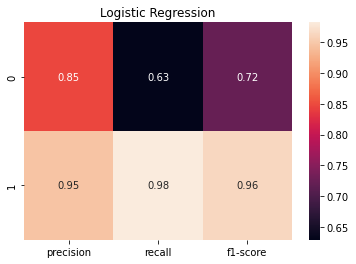

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Decision Tree
confusion matrix: 
 [[ 17217   8548]
 [  9812 159432]]


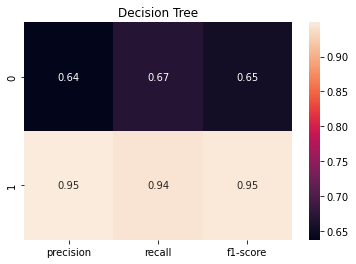

In [ ]:
# Defining models
models = [LogisticRegression(random_state=0), DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0), GradientBoostingClassifier(random_state=0), XGBClassifier(random_state=0)]
names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]

results_dt = []
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=123) 
acc = []
auc = []

# Getting scores for the different models
for model, name in zip(models, names):
  model = model.fit(X_train, y_train)
  pred = model.predict(X_val)
  
  cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc") 
  results_dt.append(cv_results)

  acc.append(cross_val_score(model, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1).mean())
  auc.append(cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()) 

  print(name)
  print("confusion matrix: \n", metrics.confusion_matrix(y_val, pred)) 
  
  #Plotting classification report
  clf_report = classification_report(y_val, pred, output_dict=True)
  plt.figure()
  plt.title(name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
  plt.show()

  print()     

In [ ]:
from sklearn.metrics import log_loss
# initializing all the model objects with default parameters
model_1 = LogisticRegression()
model_2 = RandomForestClassifier()
model_3 = XGBClassifier()

 
# Making the final model using voting classifier
ensemble_model = VotingClassifier(estimators=[('lr', model_1), ('rf', model_2), ('xgb', model_3) ], 
                                  voting='hard')
 
# training all the model on the train dataset
ensemble_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_ensemble = ensemble_model.predict(X_val)

# printing log loss between actual and predicted value
print(log_loss(y_test, pred_ensemble))

In [ ]:
### Ensembling

# Different evaluation metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_val, pred_ensemble)) #AUC-ROC
print("\n confusion matrix: \n", metrics.plot_confusion_matrix(ensemble_model, X_val, y_val)) 
print()

# Plotting classification report
clf_report_emsemble = classification_report(y_val, pred_ensemble, output_dict=True)
plt.figure()

plt.title("Emsembling")
sns.heatmap(pd.DataFrame(clf_report_emsemble).iloc[:-1, :-3].T, annot=True) # retains only precision, recall, F1 score for both classes
plt.show()

In [ ]:
# Accuracy and AUC-ROC Scores
scores = pd.DataFrame(list(zip(names, acc, auc)), columns =["Algorithm", "Accuracy Score", "AUC-ROC Score"]) 
print(scores)

# Plotting AUC-ROC
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_dt)
plt.xlabel('Algorithm')
plt.ylabel('AUC-ROC')
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.show()

In [ ]:
from numpy import sqrt 

## Calculating sample weight for XGBoost
scale_pos_weight_sqrt = sqrt(len(df_bike[df_bike['usertype'] == 'Subscriber'])/len(df_bike[df_bike['usertype'] == 'Customer']))


In [ ]:
# Adding class weight parameter
models_balanced = [DecisionTreeClassifier(random_state=0, class_weight = "balanced"), RandomForestClassifier(random_state=0, class_weight="balanced_subsample"), XGBClassifier(random_state=0, scale_pos_weight = scale_pos_weight_sqrt)]

names_balanced = ["Random Forest balance", "Logistic Regression balanced", "XGBoost balance"]
results_dt_balance = []
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0) 
acc_balance = []
auc_balance = []

# Getting scores for the different models
for model, name in zip(models_balanced, names_balanced):
  models_balanced = model.fit(X_train, y_train)
  pred = model.predict(X_val)
  
  cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc") 
  results_dt_balance.append(cv_results)

  acc_balance.append(cross_val_score(model, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1).mean())
  auc_balance.append(cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()) 

  print(name)
  print("confusion matrix: \n", metrics.confusion_matrix(y_val, pred)) 
  
  
  #Plotting classification report
  clf_report = classification_report(y_val, pred, output_dict=True)
  plt.figure()
  plt.title(name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-3].T, annot=True)
  plt.show()

  print()     

In [ ]:
df_bike = df_bike.reset_index()
# Undersampling
from sklearn.utils import resample
majority = df_bike[df_bike.usertype=="Subscriber"] # Majority class
minority = df_bike[df_bike.usertype=="Customer"] # Minority class

print("minotiry is:", df_bike[df_bike.usertype=="Customer"].value_counts())

# Random selection without replacement
majority_undersampled = resample(majority, replace=False, n_samples=38, random_state=0) # Randomly selects 38 records from majority to match minority class size

# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 38 from majority
 
df_undersampled.usertype.value_counts()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization

full_rf = RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(full_rf.get_params())

In [ ]:
full_rf.fit(x_train, y_train)

In [ ]:
plt.figure(figsize=(20,20))
tree.plot_tree(full_rf.estimators_[0], feature_names=x_train.columns, filled=True)
#plotDecisionTree(fulltree, feature_names=train_x.columns)

In [ ]:
plt.figure(figsize=(40,30))
tree.plot_tree(full_rf.estimators_[3], feature_names=x_train.columns, filled=True)

In [ ]:
sorted_idx = full_rf.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], full_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature name")

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(full_rf, x_train, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance on train data")

In [ ]:
perm_importance = permutation_importance(full_rf, x_val, y_val)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_val.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance on validation")

In [ ]:
import shap 
explainer  = shap.TreeExplainer(full_rf) 
shap_values = explainer.shap_values(x_train) 
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap_values = explainer.shap_values(x_val) 
shap.summary_plot(shap_values, x_val, plot_type="bar")

In [ ]:
y_test.shape

In [ ]:
# make predictions for test data
y_pred_test = full_rf.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy_rf = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import confusion_matrix
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Customer', 'Subscriber']
tick_marks = np.arange(len(class_names))
#tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model \n')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,15,20],
    'criterion' : ['entropy','gini'],
    'max_features': [2, 3],
    'min_samples_leaf': [5, 10, 15, 20],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)


#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
print('Initial score: ', rf_random.best_score_)
print('Initial parameters: ', rf_random.best_params_)

### RandomForst 

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
max_features = 2
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle=True)
model_rf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results_rf = model_selection.cross_val_score(model_rf, train.loc[:, train.columns != 'usertype'],
                                          train['usertype'],
                                          cv=kfold)
print(results_rf.mean(), results_rf.std())

In [ ]:
from sklearn.linear_model import LogisticRegression

# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
    # prepare the cross-validation procedure
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle=True)
    #cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # create model
    model = LogisticRegression()
    # evaluate model
    scores = model_selection.cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
    return scores

repeats = range(1,16)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(x_train, y_train, r)
	# summarize
	print('>%d mean=%.4f se=%.3f' % (r, scores.mean(), scores.std()))
	# store
	results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [ ]:
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [ ]:
model_rf.fit(train.loc[:, train.columns != 'usertype'], train['usertype'],)

from sklearn.model_selection import cross_val_score
recall    = cross_val_score(model_rf, x_train, y_train, cv=5, scoring='recall')
precision = cross_val_score(model_rf, x_train, y_train, cv=5, scoring='precision')
accuracy  = cross_val_score(model_rf, x_train, y_train, cv=5, scoring='accuracy')
f1_score  = cross_val_score(model_rf, x_train, y_train, cv=5, scoring='f1_macro')
print(recall, '\n', precision, '\n', accuracy, '\n', f1_score)

In [ ]:
def mmb_evaluate_model(self):
        """
        Returns scores from cross validation evaluation on the malicious / benign classifier
        """
        predictive_features = self.features['predictive_features']
        self.clf_X = self.modeldata[predictive_features].values
        self.clf_y = np.array(self.modeldata['label'])

        X_train, X_test, y_train, y_test = train_test_split(self.clf_X, self.clf_y, test_size=0.2, random_state=0)
        lb = LabelBinarizer()
        y_train = np.array([number[0] for number in lb.fit_transform(y_train)])
        eval_cls = RandomForestClassifier(n_estimators=100, max_features=.2)
        eval_cls.fit(X_train, y_train)

        recall = cross_val_score(eval_cls, X_train, y_train, cv=5, scoring='recall')
        precision = cross_val_score(eval_cls, X_train, y_train, cv=5, scoring='precision')
        accuracy = cross_val_score(eval_cls, X_train, y_train, cv=5, scoring='accuracy')
        f1_score = cross_val_score(eval_cls, X_train, y_train, cv=5, scoring='f1_macro')

        return {'accuracy': accuracy, 'f1': f1_score, 'precision': precision, 'recall': recall} 


### xgBoosting

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle=True)
model_xgboost = AdaBoostClassifier(n_estimators=num_trees, random_state=12)
results = model_selection.cross_val_score(model_xgboost,train.loc[:, train.columns != 'usertype'],
                                          train['usertype'], cv=kfold)

In [ ]:
# report performance
print('Accuracy: %.3f (%.3f)' % (results.mean(), results.std()))

In [ ]:
# fit model no training data
import xgboost

model_xg = xgboost.XGBClassifier()
model_xg.fit(x_train, y_train)
print(model_xg)

In [ ]:
# make predictions for test data
y_pred = model_xg.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
y_pred_test = model_rf.predict(x_test)
accuracy_score(y_test, y_pred_test)

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Customer', 'Subscriber']
tick_marks = np.arange(len(class_names))
#tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model \n')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

In [ ]:
from sklearn.ensemble import VotingClassifier

kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle=True)
# create the sub models
estimators = []
model1 = AdaBoostClassifier()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = RandomForestClassifier()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, x_train, y_train, cv=kfold)
print(results.mean())

### Stochastic 

In [ ]:

# Stochastic Gradient Boosting Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

### Ensemble

In [ ]:
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

In [ ]:
models=[]

models.append(('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis()))
models.append(('DecisionTreeClassifier',DecisionTreeClassifier()))
models.append(('KNeighborsClassifier',KNeighborsClassifier()))
models.append(('SVC',SVC()))
models.append(('GaussianNB',GaussianNB()))

for name,model in models:
    kfold=model_selection.KFold(n_splits=10,random_state=0)
    result=model_selection.cross_val_score(model,X_train,Y_train,cv=kfold,scoring='accuracy')
    print('{},{},{}'.format(name,result.mean(),result.std()))


## modelling:
https://www.kaggle.com/carolineecc/xg-boost-random-forest-ridge-lasso-regression

Bagging Ensembles including Bagged Decision Trees, Random Forest and Extra Trees.
Boosting Ensembles including AdaBoost and Stochastic Gradient Boosting.
Voting Ensembles for averaging the predictions for any arbitrary models.
